In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

NameError: ignored

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle config set -n path -v{}

- path is now set to: {}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions list

ref                                               deadline             category            reward  teamCount  userHasEntered  
------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                  2030-01-01 00:00:00  Getting Started  Knowledge       3202           False  
titanic                                           2030-01-01 00:00:00  Getting Started  Knowledge      23941           False  
house-prices-advanced-regression-techniques       2030-01-01 00:00:00  Getting Started  Knowledge       5429            True  
connectx                                          2030-01-01 00:00:00  Getting Started  Knowledge        387           False  
nlp-getting-started                               2030-01-01 00:00:00  Getting Started      Kudos       1716           False  
competitive-data-science-predict-future-sales     2020-12-31 23:59:00  Playground           Kudos       7273   

In [ ]:
!kaggle competitions list -s nyc-taxi-trip-duration

ref                     deadline             category     reward  teamCount  userHasEntered  
----------------------  -------------------  ----------  -------  ---------  --------------  
nyc-taxi-trip-duration  2017-09-15 23:59:00  Playground  $30,000       1257            True  


In [ ]:
!kaggle competitions download -c nyc-taxi-trip-duration

test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!kaggle competitions download -c nyc-taxi-trip-duration -p /content
!unzip \*.zip

train.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sample_submission.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   

Archive:  train.zip
  inflating: train.csv               

Archive:  test.zip
  inflating: test.csv                

3 archives were successfully processed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.utils import shuffle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train=pd.read_csv('/content/train.csv')

In [ ]:
test=pd.read_csv('/content/test.csv')

In [ ]:
test.info(),train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor

(None, None)

In [ ]:
test.shape[0]/train.shape[0]

0.42857201620134866

In [ ]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [ ]:
test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

In [ ]:
print(min(train['pickup_latitude']),max(train['pickup_latitude']))

34.359695434570305 51.88108444213867


In [ ]:
#min_latitude=train['pickup_latitude'].mean()-3*np.std(train['pickup_latitude'])
#max_latitude=train['pickup_latitude'].mean()+3*np.std(train['pickup_latitude'])
#min_longitude=train['pickup_longitude'].mean()-3*np.std(train['pickup_longitude'])
#max_longitude=train['pickup_longitude'].mean()+3*np.std(train['pickup_longitude'])
max_latitude=40.85
min_latitude=40.63
max_longitude=-73.75
min_longitude=-74.03
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

min_latitude,max_latitude,min_longitude,max_longitude

(40.63, 40.85, -74.03, -73.75)

In [ ]:
real_size=train.shape[0]
train = train[train['pickup_longitude'] <= max_longitude]
#print(train.shape)
train = train[train['pickup_longitude'] >= min_longitude]
train = train[train['pickup_latitude'] <= max_latitude]
train = train[train['pickup_latitude'] >= min_latitude]
train = train[train['dropoff_longitude'] <= max_longitude]
train = train[train['dropoff_longitude'] >= min_longitude]
train = train[train['dropoff_latitude'] <= max_latitude]
train = train[train['dropoff_latitude'] >= min_latitude]
now_size=train.shape[0]
print(now_size/real_size)


0.9866581564795797


978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
            ...   
1034341          1
207497           1
467645           1
761666           1
767271           1
Name: trip_duration, Length: 1439183, dtype: int64
0.9999972206453245


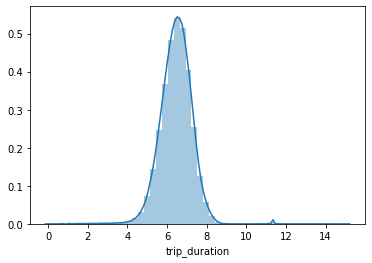

In [ ]:
z=train['trip_duration']
print(z.sort_values(ascending=False))
sns.distplot(np.log(z))
z.mean()
real_size=train.shape[0]
train=train[train['trip_duration']<=86392]
now_size=train.shape[0]
print(now_size/real_size)

In [ ]:
train['pickup_datetime'][0]

'2016-03-14 17:24:55'

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [ ]:
train['pickup_datetime']
test['pickup_datetime']

0        2016-06-30 23:59:58
1        2016-06-30 23:59:53
2        2016-06-30 23:59:47
3        2016-06-30 23:59:41
4        2016-06-30 23:59:33
                 ...        
625129   2016-01-01 00:02:52
625130   2016-01-01 00:01:52
625131   2016-01-01 00:01:24
625132   2016-01-01 00:00:28
625133   2016-01-01 00:00:22
Name: pickup_datetime, Length: 625134, dtype: datetime64[ns]

In [ ]:
train.loc[:, 'pick_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pick_date'] = test['pickup_datetime'].dt.date

In [ ]:

train['pick_date']
test['pick_date']

0         2016-06-30
1         2016-06-30
2         2016-06-30
3         2016-06-30
4         2016-06-30
             ...    
625129    2016-01-01
625130    2016-01-01
625131    2016-01-01
625132    2016-01-01
625133    2016-01-01
Name: pick_date, Length: 625134, dtype: object

In [ ]:
# plt.figure(figsize=(10,15))
# plt.plot(train.groupby(['pick_date']).count(),color='red')
# plt.plot(test.groupby(['pick_date']).count(),color='green')


In [ ]:
train['pick_month'] = train['pickup_datetime'].dt.month
train['pick_hour']=train['pickup_datetime'].dt.hour
train['pick_day']=train['pickup_datetime'].dt.dayofweek

test['pick_month'] = test['pickup_datetime'].dt.month
test['pick_hour']=test['pickup_datetime'].dt.hour
test['pick_day']=test['pickup_datetime'].dt.dayofweek


In [ ]:
# train['pick_month']
# z=train['pickup_datetime'].dt.dayofweek

In [ ]:
z.nunique()

7311

In [ ]:
# plt.plot(train.groupby('pick_day')['trip_duration'].mean(),'-')
# plt.xlabel('Day Of Week')
# plt.ylabel('Mean Trip Duration')

In [ ]:
# plt.plot(train.groupby('passenger_count')['trip_duration'].mean(),'-o')

In [ ]:
# train.groupby('passenger_count').count()
# #sns.distplot(train.groupby('passenger_count').count())

In [ ]:
train.groupby('vendor_id').count()

,id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_date,pick_month,pick_hour,pick_day
vendor_id,,,,,,,,,,,,,,
1,669297,669297,669297,669297,669297,669297,669297,669297,669297,669297,669297,669297,669297,669297
2,769882,769882,769882,769882,769882,769882,769882,769882,769882,769882,769882,769882,769882,769882


In [ ]:
# temp=train.groupby('vendor_id')['trip_duration'].mean()
# sns.barplot(temp.index,temp.values)

In [ ]:
# sns.scatterplot(train['vendor_id'],train['trip_duration'])

In [ ]:
print(train.head(),test.head())

          id  vendor_id     pickup_datetime  ... pick_month  pick_hour  pick_day
0  id2875421          2 2016-03-14 17:24:55  ...          3         17         0
1  id2377394          1 2016-06-12 00:43:35  ...          6          0         6
2  id3858529          2 2016-01-19 11:35:24  ...          1         11         1
3  id3504673          2 2016-04-06 19:32:31  ...          4         19         2
4  id2181028          2 2016-03-26 13:30:55  ...          3         13         5

[5 rows x 15 columns]           id  vendor_id     pickup_datetime  ...  pick_month  pick_hour  pick_day
0  id3004672          1 2016-06-30 23:59:58  ...           6         23         3
1  id3505355          1 2016-06-30 23:59:53  ...           6         23         3
2  id1217141          1 2016-06-30 23:59:47  ...           6         23         3
3  id2150126          2 2016-06-30 23:59:41  ...           6         23         3
4  id1598245          1 2016-06-30 23:59:33  ...           6         23         3

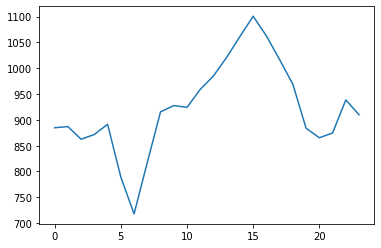

In [ ]:
temp=train.groupby('pick_hour')['trip_duration'].mean()
plt.plot(temp.values)

In [ ]:
# plt.scatter(train['pickup_longitude'],train['pickup_latitude'],color='blue', s=1, label='train', alpha=0.1)
# fig, ax = plt.subplots(ncols=1, nrows=1)
# ax.scatter(test.pickup_longitude.values[:500000], test.pickup_latitude.values[:500000], s=10, lw=0, color='red', alpha=0.2)
# ax.set_xlim(city_long_border)
# ax.set_ylim(city_lat_border)
# #x[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
# #              )

In [ ]:
coordinates=np.vstack((train[['pickup_latitude','pickup_longitude']].values,
                     train[['dropoff_latitude','dropoff_longitude']].values
                     ))
print(coordinates[2])

[ 40.7639389  -73.97902679]


In [ ]:
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coordinates)

In [ ]:
train[['pickup_latitude','pickup_longitude']].values[0]
temp=kmeans.predict(train[['pickup_latitude','pickup_longitude']].values.reshape(-1,2))

In [ ]:
# plt.figure(figsize=(15,15))
# plt.scatter(train['pickup_longitude'],train['pickup_latitude'],c=temp, s=1, label='train', alpha=0.1,cmap='plasma')

In [ ]:
train['pickup_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']].values.reshape(-1,2))
train['dropoff_cluster']=kmeans.predict(train[['dropoff_latitude','dropoff_longitude']].values.reshape(-1,2))
test['pickup_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']].values.reshape(-1,2))
test['dropoff_cluster']=kmeans.predict(test[['dropoff_latitude','dropoff_longitude']].values.reshape(-1,2))


In [ ]:
print(train.head(),test.head())

          id  vendor_id  ... pickup_cluster dropoff_cluster
0  id2875421          2  ...             60               1
1  id2377394          1  ...             62              12
2  id3858529          2  ...             90              45
3  id3504673          2  ...              0              25
4  id2181028          2  ...             54              14

[5 rows x 17 columns]           id  vendor_id  ... pickup_cluster  dropoff_cluster
0  id3004672          1  ...             40               33
1  id3505355          1  ...             20               87
2  id1217141          1  ...             58                7
3  id2150126          2  ...             64                7
4  id1598245          1  ...             67               79

[5 rows x 15 columns]


In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b
def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [ ]:
train['manhattan_distance']=dummy_manhattan_distance(train['pickup_latitude'],train['pickup_longitude'],train['dropoff_latitude'],train['dropoff_longitude'])
test['manhattan_distance']=dummy_manhattan_distance(test['pickup_latitude'],test['pickup_longitude'],test['dropoff_latitude'],test['dropoff_longitude'])


In [ ]:
train['direction']=ft_degree(train['pickup_latitude'],train['pickup_longitude'],train['dropoff_latitude'],train['dropoff_longitude'])
test['direction']=ft_degree(test['pickup_latitude'],test['pickup_longitude'],test['dropoff_latitude'],test['dropoff_longitude'])
test['direction'][:4]

0     -3.595224
1    172.278835
2    133.326248
3   -150.956833
Name: direction, dtype: float64

In [ ]:
train['traffic_speed']=(train['manhattan_distance']/train['trip_duration'])*1000
print(train.head(),test.head())

          id  vendor_id  ...   direction traffic_speed
0  id2875421          2  ...   99.970196      3.814139
1  id2377394          1  ... -117.153768      3.665922
2  id3858529          2  ... -159.680165      3.862323
3  id3504673          2  ... -172.737700      3.872567
4  id2181028          2  ...  179.473585      2.757372

[5 rows x 20 columns]           id  vendor_id  ... manhattan_distance   direction
0  id3004672          1  ...           2.913304   -3.595224
1  id3505355          1  ...           3.104805  172.278835
2  id1217141          1  ...           1.846340  133.326248
3  id2150126          2  ...           7.163347 -150.956833
4  id1598245          1  ...           1.354164  130.260381

[5 rows x 17 columns]


In [ ]:
# plt.figure(figsize=(15,15))
# fig, ax = plt.subplots(ncols=3, nrows=1)
# temp=train.groupby(['pick_day'])['traffic_speed'].mean();
# ax[0].plot(temp.index,temp.values,'-o')
# ax[0].set_xlabel('Speed By Day Of Week')
# temp=train.groupby(['pick_month'])['traffic_speed'].mean();
# ax[1].plot(temp.index,temp.values,'-o',color='red')
# ax[1].set_xlabel('Speed By Month')
# temp=train.groupby(['pick_hour'])['traffic_speed'].mean();
# ax[2].plot(temp.index,temp.values,'-o',color='purple',lw=2, alpha=0.7)
# ax[2].set_xlabel('Speed By Hour Of Day')


In [ ]:
train.shape

(1439179, 20)

In [ ]:
vendor_id=pd.get_dummies(train['vendor_id'],prefix='vendor_id')
passenger_count=pd.get_dummies(train['passenger_count'],prefix='passenger_count')
store_and_fwd_flag=pd.get_dummies(train['store_and_fwd_flag'],prefix='store_and_fwd_flag')
pick_month=pd.get_dummies(train['pick_month'],prefix='pick_month')
pick_hour=pd.get_dummies(train['pick_hour'],prefix='pick_hour')
pick_day=pd.get_dummies(train['pick_day'],prefix='pick_day')
pickup_cluster=pd.get_dummies(train['pickup_cluster'],prefix='pickup_cluster')
dropoff_cluster=pd.get_dummies(train['dropoff_cluster'],prefix='dropoff_cluster')


vendor_id1=pd.get_dummies(test['vendor_id'],prefix='vendor_id')
passenger_count1=pd.get_dummies(test['passenger_count'],prefix='passenger_count')
store_and_fwd_flag1=pd.get_dummies(test['store_and_fwd_flag'],prefix='store_and_fwd_flag')
pick_month1=pd.get_dummies(test['pick_month'],prefix='pick_month')
pick_hour1=pd.get_dummies(test['pick_hour'],prefix='pick_hour')
pick_day1=pd.get_dummies(test['pick_day'],prefix='pick_day')
pickup_cluster1=pd.get_dummies(test['pickup_cluster'],prefix='pickup_cluster')
dropoff_cluster1=pd.get_dummies(test['dropoff_cluster'],prefix='dropoff_cluster')


In [ ]:
vendor_id.shape,vendor_id1.shape
#vendor_id

((1439179, 2), (625134, 2))

In [ ]:
passenger_count1.drop(['passenger_count_9'],axis=1,inplace=True)
passenger_count.shape,passenger_count1.shape

((1439179, 7), (625134, 7))

In [ ]:
store_and_fwd_flag.shape,store_and_fwd_flag1.shape

((1439179, 2), (625134, 2))

In [ ]:
pick_month.shape,pick_month1.shape

((1439179, 6), (625134, 6))

In [ ]:
pick_hour.shape,pick_hour1.shape

((1439179, 24), (625134, 24))

In [ ]:
pick_day.shape,pick_day1.shape

((1439179, 7), (625134, 7))

In [ ]:
pickup_cluster.shape,pickup_cluster1.shape

((1439179, 100), (625134, 100))

In [ ]:
dropoff_cluster.shape,dropoff_cluster1.shape

((1439179, 100), (625134, 100))

In [ ]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pick_date', 'pick_month', 'pick_hour', 'pick_day',
       'pickup_cluster', 'dropoff_cluster', 'manhattan_distance', 'direction',
       'traffic_speed'],
      dtype='object')

In [ ]:
train.drop(['vendor_id','pickup_datetime','dropoff_datetime','passenger_count','store_and_fwd_flag',
            'pick_month', 'pick_hour', 'pick_day','pickup_cluster','pick_date','traffic_speed','dropoff_cluster'],axis=1,inplace=True)
test.drop(['vendor_id','pickup_datetime','passenger_count','store_and_fwd_flag',
            'pick_month', 'pick_hour', 'pick_day','pickup_cluster','pick_date','dropoff_cluster'],axis=1,inplace=True)


In [ ]:
train.columns,test.columns

(Index(['id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
        'dropoff_latitude', 'trip_duration', 'manhattan_distance', 'direction'],
       dtype='object'),
 Index(['id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
        'dropoff_latitude', 'manhattan_distance', 'direction'],
       dtype='object'))

In [ ]:
train.drop(['id'],inplace=True,axis=1)
test.drop(['id'],inplace=True,axis=1)

In [ ]:
train.head(),test.head()

(   pickup_longitude  pickup_latitude  ...  manhattan_distance   direction
 0        -73.982155        40.767937  ...            1.735433   99.970196
 1        -73.980415        40.738564  ...            2.430506 -117.153768
 2        -73.979027        40.763939  ...            8.203575 -159.680165
 3        -74.010040        40.719971  ...            1.661331 -172.737700
 4        -73.973053        40.793209  ...            1.199457  179.473585
 
 [5 rows x 7 columns],
    pickup_longitude  pickup_latitude  ...  manhattan_distance   direction
 0        -73.988129        40.732029  ...            2.913304   -3.595224
 1        -73.964203        40.679993  ...            3.104805  172.278835
 2        -73.997437        40.737583  ...            1.846340  133.326248
 3        -73.956070        40.771900  ...            7.163347 -150.956833
 4        -73.970215        40.761475  ...            1.354164  130.260381
 
 [5 rows x 6 columns])

In [ ]:
merge1=train.merge(vendor_id,how='left',left_index=True,right_index=True)
merge2=test.merge(vendor_id1,how='left',left_index=True,right_index=True)


In [ ]:
merge1=merge1.merge(passenger_count,how='left',left_index=True,right_index=True)
merge2=merge2.merge(passenger_count1,how='left',left_index=True,right_index=True)


In [ ]:
merge1=merge1.merge(pick_month,how='left',left_index=True,right_index=True)
merge2=merge2.merge(pick_month1,how='left',left_index=True,right_index=True)


In [ ]:
merge1=merge1.merge(pick_hour,how='left',left_index=True,right_index=True)
merge2=merge2.merge(pick_hour1,how='left',left_index=True,right_index=True)
print(merge1.head(),merge2.head())

   pickup_longitude  pickup_latitude  ...  pick_hour_22  pick_hour_23
0        -73.982155        40.767937  ...             0             0
1        -73.980415        40.738564  ...             0             0
2        -73.979027        40.763939  ...             0             0
3        -74.010040        40.719971  ...             0             0
4        -73.973053        40.793209  ...             0             0

[5 rows x 46 columns]    pickup_longitude  pickup_latitude  ...  pick_hour_22  pick_hour_23
0        -73.988129        40.732029  ...             0             1
1        -73.964203        40.679993  ...             0             1
2        -73.997437        40.737583  ...             0             1
3        -73.956070        40.771900  ...             0             1
4        -73.970215        40.761475  ...             0             1

[5 rows x 45 columns]


In [ ]:
merge1=merge1.merge(pick_day,how='left',left_index=True,right_index=True)
merge2=merge2.merge(pick_day1,how='left',left_index=True,right_index=True)
print(merge1.columns,merge2.columns)

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'manhattan_distance', 'direction',
       'vendor_id_1', 'vendor_id_2', 'passenger_count_0', 'passenger_count_1',
       'passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'pick_month_1',
       'pick_month_2', 'pick_month_3', 'pick_month_4', 'pick_month_5',
       'pick_month_6', 'pick_hour_0', 'pick_hour_1', 'pick_hour_2',
       'pick_hour_3', 'pick_hour_4', 'pick_hour_5', 'pick_hour_6',
       'pick_hour_7', 'pick_hour_8', 'pick_hour_9', 'pick_hour_10',
       'pick_hour_11', 'pick_hour_12', 'pick_hour_13', 'pick_hour_14',
       'pick_hour_15', 'pick_hour_16', 'pick_hour_17', 'pick_hour_18',
       'pick_hour_19', 'pick_hour_20', 'pick_hour_21', 'pick_hour_22',
       'pick_hour_23', 'pick_day_0', 'pick_day_1', 'pick_day_2', 'pick_day_3',
       'pick_day_4', 'pick_day_5', 'pick_day_6'],
      dtype='object') In

In [ ]:
merge1=merge1.merge(pickup_cluster,how='left',left_index=True,right_index=True)
merge2=merge2.merge(pickup_cluster1,how='left',left_index=True,right_index=True)


In [ ]:
merge1=merge1.merge(dropoff_cluster,how='left',left_index=True,right_index=True)
merge2=merge2.merge(dropoff_cluster1,how='left',left_index=True,right_index=True)

In [ ]:
merge1.shape,merge2.shape

((1439179, 253), (625134, 252))

In [ ]:
X=merge1.drop(['trip_duration'],axis=1)[:1100000]

In [ ]:
y=np.log(merge1['trip_duration'])[:1100000]

In [ ]:
df1,df2,y_train,y_test=train_test_split(X,y,test_size=0.25)

In [ ]:
df1.shape,df2.shape

((825000, 252), (275000, 252))

In [ ]:
print(merge1.columns)

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'manhattan_distance', 'direction',
       'vendor_id_1', 'vendor_id_2', 'passenger_count_0',
       ...
       'dropoff_cluster_90', 'dropoff_cluster_91', 'dropoff_cluster_92',
       'dropoff_cluster_93', 'dropoff_cluster_94', 'dropoff_cluster_95',
       'dropoff_cluster_96', 'dropoff_cluster_97', 'dropoff_cluster_98',
       'dropoff_cluster_99'],
      dtype='object', length=253)


In [ ]:
xgb_pars = {'min_child_weight': 100, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [ ]:
dtrain = xgb.DMatrix(X, label=y)
dtrain

In [ ]:
dtrain = xgb.DMatrix(df1, label=y_train)
dvalid = xgb.DMatrix(df2, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=4,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:3.03398	valid-rmse:3.03295
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 4 rounds.
[1]	train-rmse:1.57482	valid-rmse:1.57335
[2]	train-rmse:0.888469	valid-rmse:0.886439
[3]	train-rmse:0.603126	valid-rmse:0.600604
[4]	train-rmse:0.503637	valid-rmse:0.50094
[5]	train-rmse:0.471449	valid-rmse:0.468879
[6]	train-rmse:0.453451	valid-rmse:0.451017
[7]	train-rmse:0.446992	valid-rmse:0.444818
[8]	train-rmse:0.442847	valid-rmse:0.440939
[9]	train-rmse:0.437332	valid-rmse:0.435441
Modeling RMSLE 0.43544


In [ ]:
temp=xgb.DMatrix(merge2)
predict=model.predict(temp)

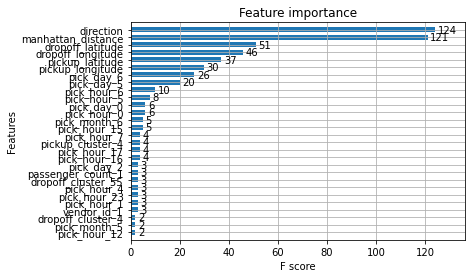

In [ ]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

In [ ]:
result=pd.read_csv('/content/sample_submission.csv')

#submission = pd.concat([Test_id, pd.DataFrame(predict)], axis=1)
#submission.columns = ['id','trip_duration']
#submission.to_csv("sample_submission.csv", index=False)

In [ ]:
ans=pd.DataFrame(np.exp(predict))
result=result.merge(ans,how='left',left_index=True,right_index=True)

In [ ]:
result

,id,trip_duration,0
0,id3004672,959,761.053467
1,id3505355,959,762.603577
2,id1217141,959,470.041534
3,id2150126,959,1154.330933
4,id1598245,959,422.251007
...,...,...,...
625129,id3008929,959,264.669434
625130,id3700764,959,1208.925781
625131,id2568735,959,1465.089233
625132,id1384355,959,1607.101196


In [ ]:
result.drop(['trip_duration'],axis=1,inplace=True)

In [ ]:
result

,id,0
0,id3004672,761.053467
1,id3505355,762.603577
2,id1217141,470.041534
3,id2150126,1154.330933
4,id1598245,422.251007
...,...,...
625129,id3008929,264.669434
625130,id3700764,1208.925781
625131,id2568735,1465.089233
625132,id1384355,1607.101196


In [ ]:
result.columns = ['id','trip_duration']

In [ ]:
result

,id,trip_duration
0,id3004672,761.053467
1,id3505355,762.603577
2,id1217141,470.041534
3,id2150126,1154.330933
4,id1598245,422.251007
...,...,...
625129,id3008929,264.669434
625130,id3700764,1208.925781
625131,id2568735,1465.089233
625132,id1384355,1607.101196


In [ ]:
result.to_csv("submission.csv", index=False)

In [ ]:
pd.read_csv("submission.csv")

,id,trip_duration
0,id3004672,761.05347
1,id3505355,762.60360
2,id1217141,470.04153
3,id2150126,1154.33090
4,id1598245,422.25100
...,...,...
625129,id3008929,264.66943
625130,id3700764,1208.92580
625131,id2568735,1465.08920
625132,id1384355,1607.10120


In [ ]:
!kaggle competitions submit -c nyc-taxi-trip-duration -f submission.csv -m 'answerr'

100% 11.7M/11.7M [00:01<00:00, 10.5MB/s]
Successfully submitted to New York City Taxi Trip Duration